# Mini-projekt (DP): Co zmienia optymalną politykę i wartość startu?

## Rozwiązanie

### Kontekst
W rozdziale 4 zrobiliśmy Dynamic Programming dla tablicowych MDP:
- mamy **model** środowiska w postaci `P[s][a] = [(p, s2, r, terminated), ...]`,
- umiemy liczyć: `v_pi` (policy evaluation), poprawiać politykę (policy improvement),
- znajdować optimum: `pi*`, `v*` (policy iteration / value iteration).

### Wybrane pytania badawcze
- **Pytanie A**: Wpływ gamma na v*(start)
- **Pytanie B**: Deterministyczne vs slippery (FrozenLake)

---
## Import bibliotek i funkcje pomocnicze

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def pretty_matrix_as_grid(v, nrow, ncol, decimals=1):
    grid = np.asarray(v, dtype=float).reshape(nrow, ncol)
    with np.printoptions(precision=decimals, suppress=True):
        print(grid)

def action_arrows(pi_det, nrow, ncol, arrows):
    out = []
    for r in range(nrow):
        row = []
        for c in range(ncol):
            s = r * ncol + c
            a = int(pi_det[s])
            row.append(arrows.get(a, '?'))
        out.append(' '.join(row))
    print('\n'.join(out))

def one_hot_policy(pi_det, nA):
    nS = pi_det.shape[0]
    pi = np.zeros((nS, nA), dtype=float)
    pi[np.arange(nS), pi_det.astype(int)] = 1.0
    return pi

---
## Budowanie srodowisk

In [12]:
def build_gridworld_AB_P():
    """Gridworld 5x5 z A/B teleportami (jak w rozdz. 3).

    Akcje (dla Gridworld): 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT.
    Przejścia są deterministyczne: P[s][a] ma jeden wpis z p=1.0.

    Zwraca: P, nS, nA, nrow, ncol
    """
    nrow, ncol = 5, 5
    nS, nA = nrow * ncol, 4
    P = {s: {a: [] for a in range(nA)} for s in range(nS)}

    # Specjalne pozycje A/B
    A = (0, 1); Aprime = (4, 1); reward_A = 10.0
    B = (0, 3); Bprime = (2, 3); reward_B = 5.0

    def s2pos(s):
        return (s // ncol, s % ncol)

    def pos2s(r, c):
        return r * ncol + c

    moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}

    for s in range(nS):
        r, c = s2pos(s)

        # teleporty mają priorytet
        if (r, c) == A:
            s2 = pos2s(*Aprime)
            for a in range(nA):
                P[s][a] = [(1.0, s2, reward_A, False)]
            continue
        if (r, c) == B:
            s2 = pos2s(*Bprime)
            for a in range(nA):
                P[s][a] = [(1.0, s2, reward_B, False)]
            continue

        # standardowe ruchy + kara za wyjście poza planszę
        for a in range(nA):
            dr, dc = moves[a]
            r2, c2 = r + dr, c + dc
            if (r2 < 0) or (r2 >= nrow) or (c2 < 0) or (c2 >= ncol):
                s2 = s
                reward = -1.0
            else:
                s2 = pos2s(r2, c2)
                reward = 0.0
            P[s][a] = [(1.0, s2, reward, False)]

    return P, nS, nA, nrow, ncol

In [13]:
def build_frozenlake_P(desc, is_slippery: bool = False):
    """
    Buduje model FrozenLake w formacie P[s][a] bez użycia Gym.

    desc: lista stringów opisujących mapę, np.
          ["SFFF",
           "FHFH",
           "FFFH",
           "HFFG"]

    Konwencja akcji (jak w Gym):
      0 = LEFT, 1 = DOWN, 2 = RIGHT, 3 = UP

    Nagroda:
      +1 za wejście na G, w pozostałych przypadkach 0.

    Stany terminalne:
      H (hole) i G (goal).
    """

    # Zamieniamy opis mapy na tablicę znaków
    desc = np.asarray([list(row) for row in desc], dtype='<U1')
    nrow, ncol = desc.shape
    nS, nA = nrow * ncol, 4   # liczba stanów i akcji

    # Indeksy akcji (zgodne z Gym)
    LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3

    # Wektory ruchu dla każdej akcji
    moves = {
        LEFT:  (0, -1),
        DOWN:  (1,  0),
        RIGHT: (0,  1),
        UP:    (-1, 0),
    }

    # Zamiana (r, c) -> indeks stanu
    def to_s(r, c):
        return r * ncol + c

    # Jeden krok z pozycji (r, c) dla akcji a
    def step_from(r, c, a):
        dr, dc = moves[a]
        r2, c2 = r + dr, c + dc

        # FrozenLake: wyjście poza planszę = zostajemy w miejscu
        if (r2 < 0) or (r2 >= nrow) or (c2 < 0) or (c2 >= ncol):
            r2, c2 = r, c

        return r2, c2

    # Inicjalizacja struktury P[s][a]
    P = {s: {a: [] for a in range(nA)} for s in range(nS)}

    # Iterujemy po wszystkich polach planszy
    for r in range(nrow):
        for c in range(ncol):
            s = to_s(r, c)
            tile = desc[r, c]

            # Stany terminalne (H i G):
            # są absorbujące — niezależnie od akcji zostajemy w tym samym stanie
            if tile in ('H', 'G'):
                for a in range(nA):
                    P[s][a] = [(1.0, s, 0.0, True)]
                continue

            # Stany nieterminalne
            for a in range(nA):
                outcomes = []

                # Wersja śliska: akcja nie realizuje się dokładnie
                if is_slippery:
                    # Faktyczna akcja to a-1, a, a+1 z prawd. 1/3
                    candidates = [(a - 1) % 4, a, (a + 1) % 4]
                    probs = [1/3, 1/3, 1/3]
                else:
                    # Wersja deterministyczna
                    candidates = [a]
                    probs = [1.0]

                # Dla każdej możliwej „rzeczywistej” akcji
                for a_real, p in zip(candidates, probs):
                    r2, c2 = step_from(r, c, a_real)
                    s2 = to_s(r2, c2)
                    tile2 = desc[r2, c2]

                    # Sprawdzamy, czy trafiliśmy w stan terminalny
                    terminated = tile2 in ('H', 'G')

                    # Nagroda tylko za wejście na G
                    reward = 1.0 if tile2 == 'G' else 0.0

                    outcomes.append((float(p), int(s2), float(reward), bool(terminated)))

                # Scalanie identycznych następstw
                # (różne a_real mogą prowadzić do tego samego s2)
                merged = {}
                for p, s2, rwd, term in outcomes:
                    key = (s2, rwd, term)
                    merged[key] = merged.get(key, 0.0) + p

                # Finalna lista wyników dla (s, a)
                P[s][a] = [
                    (p, s2, rwd, term)
                    for (s2, rwd, term), p in merged.items()
                ]

    return P, nS, nA, nrow, ncol, desc

---
## Algorytmy DP

In [14]:
def iterative_policy_evaluation(P, pi, gamma=0.9, theta=1e-10, max_iters=100000):
    nS, nA = pi.shape
    v = np.zeros(nS, dtype=float)
    for _ in range(max_iters):
        delta = 0.0
        for s in range(nS):
            v_old = v[s]
            v_new = 0.0
            for a in range(nA):
                pi_a = pi[s, a]
                if pi_a == 0.0: continue
                for (p, s2, r, terminated) in P[s][a]:
                    if terminated: v_new += pi_a * p * r
                    else: v_new += pi_a * p * (r + gamma * v[s2])
            v[s] = v_new
            delta = max(delta, abs(v_old - v_new))
        if delta < theta: break
    return v

def greedy_policy_from_v(P, v, gamma=0.9):
    nS, nA = len(P), len(P[0])
    pi_det = np.zeros(nS, dtype=int)
    for s in range(nS):
        q_values = np.zeros(nA)
        for a in range(nA):
            q = 0.0
            for (p, s2, r, terminated) in P[s][a]:
                if terminated: q += p * r
                else: q += p * (r + gamma * v[s2])
            q_values[a] = q
        pi_det[s] = np.argmax(q_values)
    return pi_det

def policy_iteration(P, gamma=0.9, theta=1e-10, max_iters=1000):
    nS, nA = len(P), len(P[0])
    pi = np.ones((nS, nA), dtype=float) / nA
    for _ in range(max_iters):
        v = iterative_policy_evaluation(P, pi, gamma=gamma, theta=theta)
        pi_det_new = greedy_policy_from_v(P, v, gamma=gamma)
        pi_new = one_hot_policy(pi_det_new, nA)
        if np.array_equal(pi, pi_new): break
        pi = pi_new
    return pi_det_new, v

def value_iteration(P, gamma=0.9, theta=1e-10, max_iters=100000):
    nS, nA = len(P), len(P[0])
    v = np.zeros(nS, dtype=float)
    for _ in range(max_iters):
        delta = 0.0
        for s in range(nS):
            v_old = v[s]
            q_values = np.zeros(nA)
            for a in range(nA):
                q = 0.0
                for (p, s2, r, terminated) in P[s][a]:
                    if terminated: q += p * r
                    else: q += p * (r + gamma * v[s2])
                q_values[a] = q
            v[s] = np.max(q_values)
            delta = max(delta, abs(v_old - v[s]))
        if delta < theta: break
    pi_det = greedy_policy_from_v(P, v, gamma=gamma)
    return pi_det, v

---
## Inicjalizacja srodowisk

In [15]:
P_gw, nS_gw, nA_gw, nrow_gw, ncol_gw = build_gridworld_AB_P()
desc4 = ['SFFF', 'FHFH', 'FFFH', 'HFFG']
P_fl_det, nS_fl, nA_fl, nrow_fl, ncol_fl, desc_fl = build_frozenlake_P(desc4, is_slippery=False)
P_fl_slip, _, _, _, _, _ = build_frozenlake_P(desc4, is_slippery=True)

arrows_gw = {0:'up', 1:'right', 2:'down', 3:'left'}
arrows_fl = {0:'left', 1:'down', 2:'right', 3:'up'}

print('Srodowiska zbudowane!')
print(f'Gridworld: {nS_gw} stanow, {nA_gw} akcji')
print(f'FrozenLake: {nS_fl} stanow, {nA_fl} akcji')

Srodowiska zbudowane!
Gridworld: 25 stanow, 4 akcji
FrozenLake: 16 stanow, 4 akcji


---
## Krok 2: Punkt odniesienia

In [16]:
gamma_base = 0.99
start_state = 0

pi_fl_opt, v_fl_opt = value_iteration(P_fl_det, gamma=gamma_base)
print(f'FrozenLake (det.), gamma={gamma_base}: v*(start) = {v_fl_opt[start_state]:.6f}')

pi_fl_slip_opt, v_fl_slip_opt = value_iteration(P_fl_slip, gamma=gamma_base)
print(f'FrozenLake (slippery), gamma={gamma_base}: v*(start) = {v_fl_slip_opt[start_state]:.6f}')

pi_gw_opt, v_gw_opt = value_iteration(P_gw, gamma=gamma_base)
print(f'Gridworld, gamma={gamma_base}: v*(start) = {v_gw_opt[start_state]:.6f}')

FrozenLake (det.), gamma=0.99: v*(start) = 0.950990
FrozenLake (slippery), gamma=0.99: v*(start) = 0.542026
Gridworld, gamma=0.99: v*(start) = 201.999798


---
## Pytanie A: Wplyw gamma na v*(start)

**Hipoteza**: Wieksze gamma zwieksza znaczenie przyszlosci i zmienia v*(start).

In [17]:
gammas = [0.8, 0.9, 0.95, 0.99, 0.999]

vstarts_fl_det = [value_iteration(P_fl_det, gamma=g)[1][start_state] for g in gammas]
vstarts_fl_slip = [value_iteration(P_fl_slip, gamma=g)[1][start_state] for g in gammas]
vstarts_gw = [value_iteration(P_gw, gamma=g)[1][start_state] for g in gammas]

print('Wyniki dla roznych gamma:')
print(f"{'gamma':<10} {'FL det':<12} {'FL slip':<12} {'Gridworld':<12}")
print('-' * 48)
for i, g in enumerate(gammas):
    print(f'{g:<10.3f} {vstarts_fl_det[i]:<12.4f} {vstarts_fl_slip[i]:<12.4f} {vstarts_gw[i]:<12.2f}')

Wyniki dla roznych gamma:
gamma      FL det       FL slip      Gridworld   
------------------------------------------------
0.800      0.3277       0.0154       11.90       
0.900      0.5905       0.0689       21.98       
0.950      0.7738       0.1805       41.99       
0.990      0.9510       0.5420       202.00      
0.999      0.9950       0.7855       2002.00     


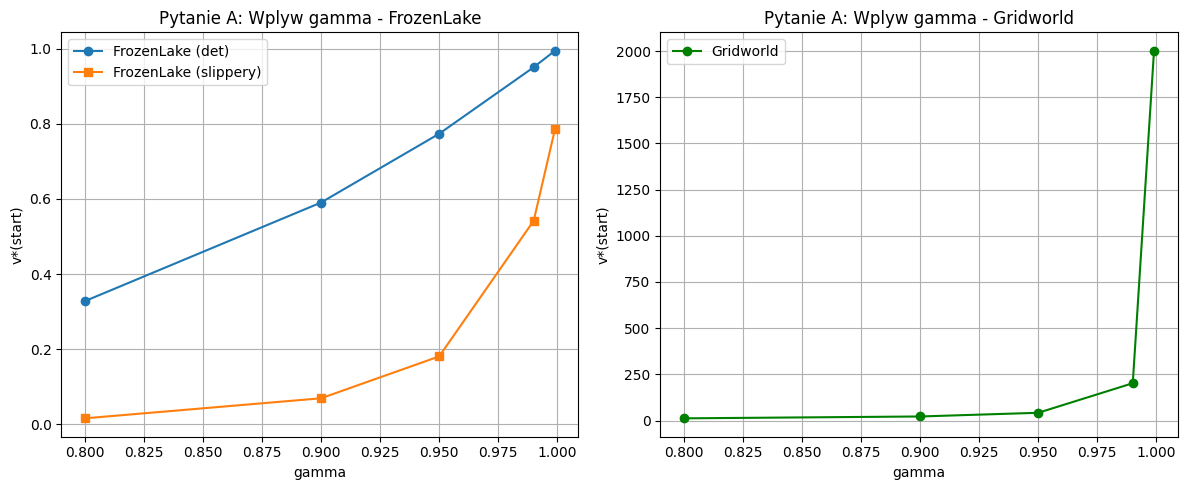

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gammas, vstarts_fl_det, 'o-', label='FrozenLake (det)')
plt.plot(gammas, vstarts_fl_slip, 's-', label='FrozenLake (slippery)')
plt.xlabel('gamma'); plt.ylabel('v*(start)')
plt.title('Pytanie A: Wplyw gamma - FrozenLake')
plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gammas, vstarts_gw, 'go-', label='Gridworld')
plt.xlabel('gamma'); plt.ylabel('v*(start)')
plt.title('Pytanie A: Wplyw gamma - Gridworld')
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

### Wnioski dla Pytania A

Wartosc v*(start) rosnie wraz ze wzrostem gamma w obu srodowiskach. W FrozenLake wzrost jest lagodny (wartosci 0-1), poniewaz jest to zadanie epizodyczne z jedna nagroda +1 na koncu. Dla gamma=0.99 mamy v*(start) okolo 0.95, co odpowiada gamma^L gdzie L to okolo 5 krokow. W Gridworld wartosci rosna wykladniczo (do 2000+ dla gamma=0.999), bo agent zbiera nagrody z teleportow w nieskonczonosc. To pokazuje, ze w zadaniach continuing parametr gamma<1 jest niezbedny dla stabilnosci.

---
## Pytanie B: Deterministyczne vs Slippery (FrozenLake)

**Hipoteza**: Stochastycznosc (slippery=True) obniza v*(start) i zmienia pi*.

In [19]:
gamma_comparison = 0.99
pi_det, v_det = value_iteration(P_fl_det, gamma=gamma_comparison)
pi_slip, v_slip = value_iteration(P_fl_slip, gamma=gamma_comparison)

print(f'Dla gamma = {gamma_comparison}:')
print(f'  Deterministyczne: v*(start) = {v_det[start_state]:.6f}')
print(f'  Slippery:         v*(start) = {v_slip[start_state]:.6f}')
print(f'  Spadek: {100*(v_det[start_state]-v_slip[start_state])/v_det[start_state]:.1f}%')

print('\nOptymalna polityka (det.):')
action_arrows(pi_det, nrow_fl, ncol_fl, arrows_fl)
print('\nOptymalna polityka (slippery):')
action_arrows(pi_slip, nrow_fl, ncol_fl, arrows_fl)

Dla gamma = 0.99:
  Deterministyczne: v*(start) = 0.950990
  Slippery:         v*(start) = 0.542026
  Spadek: 43.0%

Optymalna polityka (det.):
down right down left
down left down left
right down down left
left right right left

Optymalna polityka (slippery):
left up up up
left left left left
up down left left
left right down left


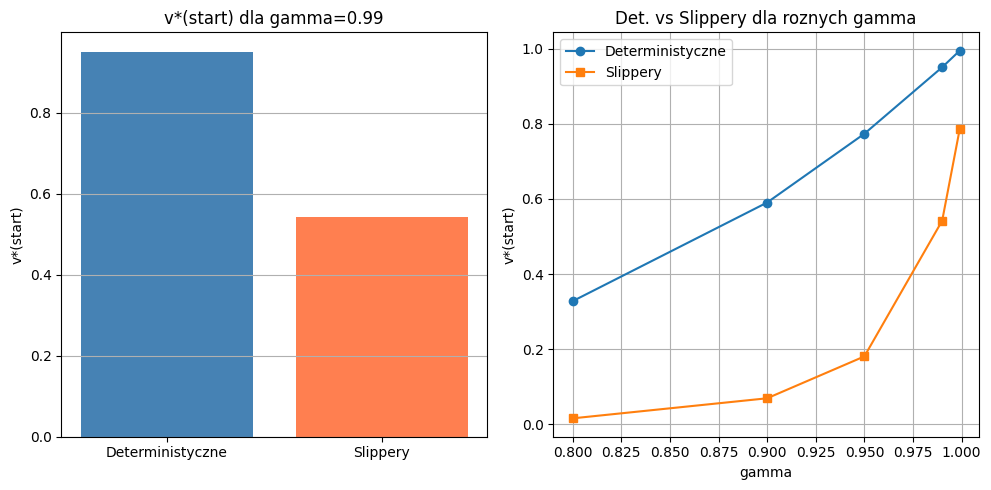

In [20]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(['Deterministyczne', 'Slippery'], [v_det[start_state], v_slip[start_state]], 
        color=['steelblue', 'coral'])
plt.ylabel('v*(start)'); plt.title(f'v*(start) dla gamma={gamma_comparison}')
plt.grid(axis='y')

plt.subplot(1, 2, 2)
plt.plot(gammas, vstarts_fl_det, 'o-', label='Deterministyczne')
plt.plot(gammas, vstarts_fl_slip, 's-', label='Slippery')
plt.xlabel('gamma'); plt.ylabel('v*(start)')
plt.title('Det. vs Slippery dla roznych gamma')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

### Wnioski dla Pytania B

Stochastycznosc znaczaco obniza v*(start) - z 0.95 do 0.54 (spadek okolo 43%) dla gamma=0.99. Agent w wersji slipery ma mniejsza kontrole nad ruchem, bo kazda akcja jest rozmyta na 3 kierunki (kazdy z p=1/3), co prowadzi do czestszego wpadania w dziury. Zmienia sie tez polityka optymalna: w wersji deterministycznej strzalki prowadza najkrotsza droga, a w slipery polityka unika ruchow przy krawedziach z dziurami, wybierajac bezpieczniejsze sciezki.

---
## Podsumowanie

**Co zmienialem:** wspolczynnik gamma (0.8-0.999) oraz typ srodowiska (det. vs slippery).

**Co zmierzylem:** wartosc stanu startowego v*(start) i ksztalt optymalnej polityki pi*.

**Glowne obserwacje:**
1. Gamma kontroluje znaczenie przyszlosci - w continuing tasks wartosci rosna dla gamma bliskiego 1.
2. Epizodyczne FrozenLake daje v*(start) przyblizenie gamma^L (L = dlugosc sciezki).
3. Stochastycznosc obniza wartosci i wymusza ostrozniejsza polityke.
4. DP daje dokladne rozwiazanie zarowno dla srodowisk deterministycznych jak i stochastycznych.